#### Final Project: Rick & Morty analysis
## Clean & Combine Data from Wiki and API

In [37]:
# import modules
import pandas as pd
import ast
import networkx as nx
import numpy as np
import urllib.request
import json
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import community
from community import community_louvain
from collections import Counter

In [38]:
df_characters = pd.read_csv("RaM_characters_wRelations.csv") # read wiki data

In [39]:
# Request API data
pages = np.arange(1, 43) # number of pages to request from the api (API use pagination)
api_base_url = "https://rickandmortyapi.com/api/character"
tpm_list_df = []


for p in pages:
    print("Page number: ", p, " out of 42")
    api_response = urllib.request.urlopen(api_base_url + "?page=" + str(p))
    api_data = api_response.read().decode("utf-8")
    
    response_data = json.loads(api_data)
    
    tmp_list_inner = []
    
    for character in response_data["results"]:  
        tpm_list_df.append([character["name"], character["status"], list(character["origin"].values())[0], character["gender"], character["species"]])
        

df_character_from_api = pd.DataFrame(tpm_list_df, columns=["Name", "Status", "Origin", "Gender", "Species"])

Page number:  1  out of 42
Page number:  2  out of 42
Page number:  3  out of 42
Page number:  4  out of 42
Page number:  5  out of 42
Page number:  6  out of 42
Page number:  7  out of 42
Page number:  8  out of 42
Page number:  9  out of 42
Page number:  10  out of 42
Page number:  11  out of 42
Page number:  12  out of 42
Page number:  13  out of 42
Page number:  14  out of 42
Page number:  15  out of 42
Page number:  16  out of 42
Page number:  17  out of 42
Page number:  18  out of 42
Page number:  19  out of 42
Page number:  20  out of 42
Page number:  21  out of 42
Page number:  22  out of 42
Page number:  23  out of 42
Page number:  24  out of 42
Page number:  25  out of 42
Page number:  26  out of 42
Page number:  27  out of 42
Page number:  28  out of 42
Page number:  29  out of 42
Page number:  30  out of 42
Page number:  31  out of 42
Page number:  32  out of 42
Page number:  33  out of 42
Page number:  34  out of 42
Page number:  35  out of 42
Page number:  36  out of 42
P

In [40]:
# APi Data and wiki data follow different format for many characters
df_character_from_api[df_character_from_api['Name'] == "Morty Smith"]

,Name,Status,Origin,Gender,Species
1,Morty Smith,Alive,unknown,Male,Human
231,Morty Smith,Alive,Earth (Evil Rick's Target Dimension),Male,Human
233,Morty Smith,Dead,Earth (Replacement Dimension),Male,Human
629,Morty Smith,Alive,Story Train,Male,Human


In [41]:
# APi Data and wiki data follow different format for many characters
df_characters[df_characters['Name'] == "Morty Smith"] 

,Name,Hyperlink,Relations
304,Morty Smith,https://rickandmorty.fandom.com/wiki/Morty_Smith,"['Jerry Smith (Cronenberged dimension)', 'Summ..."


In [42]:
# copy DF create new columns for the attributes populate them with NaN
df_character_2 = df_characters
df_character_2[["Species", "Origin", "Gender", "Status"]] = np.nan, np.nan, np.nan, np.nan
df_character_2

,Name,Hyperlink,Relations,Species,Origin,Gender,Status
0,Abandoned Jerrys,https://rickandmorty.fandom.com/wiki/Abandoned...,['Jerry Smith'],NaN,NaN,NaN,NaN
1,Abrodolph Lincoler,https://rickandmorty.fandom.com/wiki/Abrodolph...,"['Rick Sanchez', 'Brad', 'Morty Smith', 'Nancy']",NaN,NaN,NaN,NaN
2,Adam,https://rickandmorty.fandom.com/wiki/Adam,[],NaN,NaN,NaN,NaN
3,Adjudicator Rick,https://rickandmorty.fandom.com/wiki/Adjudicat...,['Evil Morty'],NaN,NaN,NaN,NaN
4,Afro Rick,https://rickandmorty.fandom.com/wiki/Afro_Rick,"['Rick Sanchez', 'Morty Smith', 'Council of Ri...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
542,Zarbadar's Mytholog,https://rickandmorty.fandom.com/wiki/Zarbadar%...,"['Gar Gloonch', 'Zarbadar Gloonch']",NaN,NaN,NaN,NaN
543,Zeep Xanflorp,https://rickandmorty.fandom.com/wiki/Zeep_Xanf...,"['Rick Sanchez', 'Chris (The Ricks Must Be Cra...",NaN,NaN,NaN,NaN
544,Zerillians,https://rickandmorty.fandom.com/wiki/Zerillians,['Jerry Smith'],NaN,NaN,NaN,NaN
545,Zeta Alpha Rick,https://rickandmorty.fandom.com/wiki/Zeta_Alph...,"['Council of Ricks', 'Rick Sanchez', 'Rick Pri...",NaN,NaN,NaN,NaN


In [43]:
def clean_compine_wiki_api_data():
    for index, row in df_character_2.iterrows():
        split_name = row.Name.split("(")
        split_name[0] = split_name[0].rstrip()
        if len(split_name) > 1:
            split_name[1] = split_name[1].replace(")", "")

            res = df_character_from_api[df_character_from_api["Name"] == split_name[0]]
            res = res[res["Origin"].str.contains(split_name[1])]
            if not res.empty:
                
                if res.Gender.item() == "unknown":
                    gender_to_use = "Genderless"
                else:
                    gender_to_use = res.Gender.item()

                df_character_2["Species"][index] = res.Species.item()
                df_character_2["Gender"][index] = gender_to_use
                df_character_2["Origin"][index] = res.Origin.item()
                df_character_2["Status"][index] = res.Status.item()

        df_to_check_name = df_character_from_api[df_character_from_api["Name"] == row.Name] 
        if not df_to_check_name.empty:
            if df_to_check_name.shape[0] == 1:
                # character exists only one with the specific name
                
                if df_to_check_name.Gender.item() == "unknown":
                    gender_to_use = "Genderless"
                else:
                    gender_to_use = df_to_check_name.Gender.item()

                df_character_2["Species"][index] = df_to_check_name.Species.item()
                df_character_2["Gender"][index] = gender_to_use
                df_character_2["Origin"][index] = df_to_check_name.Origin.item()
                df_character_2["Status"][index] = df_to_check_name.Status.item()
            else:
                # character exists more than once in the API df populate the earth data
                df_to_check_earth = df_to_check_name[df_to_check_name['Origin'] == "Earth (C-137)"]
                if not df_to_check_earth.empty:
                    if df_to_check_earth.shape[0] == 1:
                        if df_to_check_earth.Gender.item() == "unknown":
                            gender_to_use = "Genderless"
                        else:
                            gender_to_use = df_to_check_earth.Gender.item()
                        
                        df_character_2["Species"][index] = df_to_check_earth.Species.item()
                        df_character_2["Gender"][index] = gender_to_use
                        df_character_2["Origin"][index] = df_to_check_earth.Origin.item()
                        df_character_2["Status"][index] = df_to_check_earth.Status.item()
                        continue

                    # if gender is unknown use Genderless
                    df_character_2["Species"][index] = df_to_check_earth.iloc[0].Species
                    if df_to_check_earth.iloc[0].Gender == "unknown":
                        gender_to_use = "Genderless"
                    else:
                        gender_to_use = df_to_check_earth.iloc[0].Gender
                    df_character_2["Gender"][index] = gender_to_use
                    df_character_2["Origin"][index] = df_to_check_earth.iloc[0].Origin
                    df_character_2["Status"][index] = df_to_check_earth.iloc[0].Status
        else:
            df_character_2["Species"][index] = "unknown"
            df_character_2["Gender"][index] = "Genderless" # we consider all the Gender if unknows as Genderless
            df_character_2["Origin"][index] = "unknown"
            df_character_2["Status"][index] = "unknown"
    
    # the API data has almost 200 characters which we did not found from the wiki
    df_character_2.dropna(inplace=True)
    df_character_2.reset_index(drop=True, inplace=True)

In [44]:
clean_compine_wiki_api_data()

#### In the following df you can see the information for each character 

Due to the different structure/format that the wiki and the API have, further cleaning was need it for some key role characters!

In [201]:
df_characters_clean =  pd.read_csv("df_characters_with_attr_and_communities.csv") # read csv with clean data

In [202]:
df_characters_clean[df_characters_clean["Name"] == "Morty Smith"]

,Unnamed: 0,Name,Hyperlink,Relations,Species,Origin,Gender,Status,in_degree,out_degree,community
539,539,Morty Smith,https://rickandmorty.fandom.com/wiki/Morty_Smith,"['Jerry Smith (Cronenberged dimension)', 'Summ...",Human,Earth (C-137),Male,Alive,235.0,36.0,6.0


### Build the graph

In [203]:
def add_node(row, aGraph):
    """ Add the node given in row to global network """
    aGraph.add_node(row.Name)

def add_edges(row, aGraph):
    """ Add all edges which concern given character in row"""
    char_name = row.Name
    char_relations = ast.literal_eval(row.Relations)
    for aTargetRelation in char_relations:
        aGraph.add_edge(char_name,aTargetRelation)

In [204]:
# Create the associate graph with all attributes : role, race, genre, contentLength
G = nx.DiGraph()
_ = df_characters_clean.apply(add_node, args=(G,), axis=1)
_ = df_characters_clean.apply(add_edges, args=(G,), axis=1)

# Extract the Giant Connected Component, GCC
GCC = nx.weakly_connected_components(G)
GCC = list(GCC)
GCC.sort(key=len)
concerned_nodes = GCC[-1]

GCC = G.subgraph(concerned_nodes).copy()
G = GCC.copy()

# make G undirected
GU = GCC.to_undirected()

In [205]:
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 486


In [206]:
print('Number of edges:', G.number_of_edges())

Number of edges: 1996


In [207]:
# store in and out degree
df_characters_clean['in_degree'] = df_characters_clean['Name'].map(dict(G.in_degree))
df_characters_clean['out_degree'] = df_characters_clean['Name'].map(dict(G.out_degree))

In [208]:
df_characters_clean.sort_values('in_degree',ascending=False)[['Name','out_degree','in_degree']].head(10)

,Name,out_degree,in_degree
380,Rick Sanchez,40.0,271.0
539,Morty Smith,36.0,239.0
538,Jerry Smith,26.0,85.0
458,Summer Smith,30.0,73.0
42,Beth Smith,25.0,64.0
540,Evil Morty,8.0,29.0
85,Council of Ricks,14.0,27.0
471,Tammy Guterman,11.0,26.0
541,Birdperson,8.0,24.0
187,Gromflomites,7.0,23.0


In [209]:
df_characters_clean.sort_values('out_degree',ascending=False)[['Name','out_degree','in_degree']].head(10)

,Name,out_degree,in_degree
380,Rick Sanchez,40.0,271.0
539,Morty Smith,36.0,239.0
458,Summer Smith,30.0,73.0
538,Jerry Smith,26.0,85.0
42,Beth Smith,25.0,64.0
286,Memory Parasites,20.0,16.0
461,Summer Smith (Cronenberged dimension),19.0,10.0
199,Hemorrhage,18.0,16.0
296,Morty Jr.,15.0,18.0
227,Jerry Smith (Cronenberged dimension),15.0,16.0


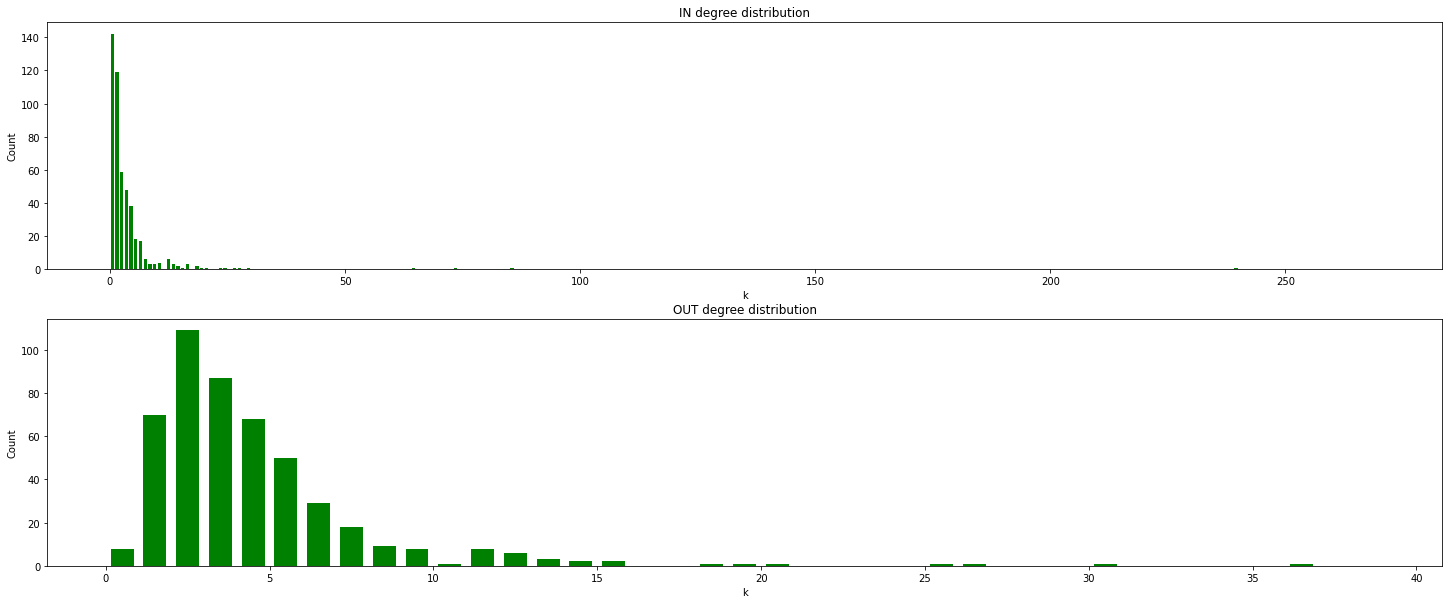

In [210]:
plt.figure(figsize=(25,10))
colors = ['green', 'blue', 'lime'] 

plt.subplot(211)
data = np.array(list(dict(G.in_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.in_degree()).values()))-min(list(dict(G.in_degree()).values()))), rwidth=0.7, color="green")
plt.title("IN degree distribution")
plt.ylabel("Count")
plt.xlabel("k")

plt.subplot(212)
plt.title("OUT degree distribution")
plt.ylabel("Count")
plt.xlabel("k")
data = np.array(list(dict(G.out_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.out_degree()).values()))-min(list(dict(G.out_degree()).values()))), rwidth=0.7, color="green")


plt.show()

In [211]:
nodes_species = {}
nodes_origin = {}
nodes_gender = {}
nodes_status = {}

for node in list(GU.nodes()):
    
    if not df_characters_clean[df_characters_clean["Name"] == node]["Species"].empty:
        nodes_species[node] = df_characters_clean[df_characters_clean["Name"] == node]["Species"].item()
        nodes_origin[node] = df_characters_clean[df_characters_clean["Name"] == node]["Origin"].item()
        nodes_gender[node] = df_characters_clean[df_characters_clean["Name"] == node]["Gender"].item()
        nodes_status[node] = df_characters_clean[df_characters_clean["Name"] == node]["Status"].item()
    else:
        nodes_species[node] = "unknown"
        nodes_origin[node] = "unknown"
        nodes_gender[node] = "Genderless"
        nodes_status[node] = "unknown"
    
    if nodes_gender[node] == "unknown":
        nodes_gender[node] = "Genderless"
    
nx.set_node_attributes(GU, nodes_species, "Species")
nx.set_node_attributes(GU, nodes_gender, "Gender")
nx.set_node_attributes(GU, nodes_origin, "Origin")
nx.set_node_attributes(GU, nodes_status, "Status")


##### In order to draw the graph we have to remove the loops among the character (character refers to each self)

In [212]:
G_to_draw = GU.copy()

In [213]:
G_to_draw.remove_edges_from(nx.selfloop_edges(G_to_draw)) # remove self loops characters pointing to themselves 

In [214]:
# set node color and size 
get_color = {'Female':'green','Genderless':'blue', "Male": "purple"}

colors_list, size_list = [], []
for nodeName, nodeAttributes in list(G_to_draw.nodes(data=True)):
    # color nodes according to the role)
    colors_list.append(get_color[nodeAttributes['Gender']])
    # scale node-size according to degree
    size_list.append(G_to_draw.degree(nodeName))

size_list = list(20*np.array(size_list))
d = dict(GU.degree)

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 440.68it/s]

BarnesHut Approximation  took  1.63  seconds
Repulsion forces  took  2.54  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


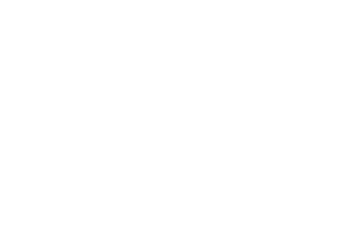

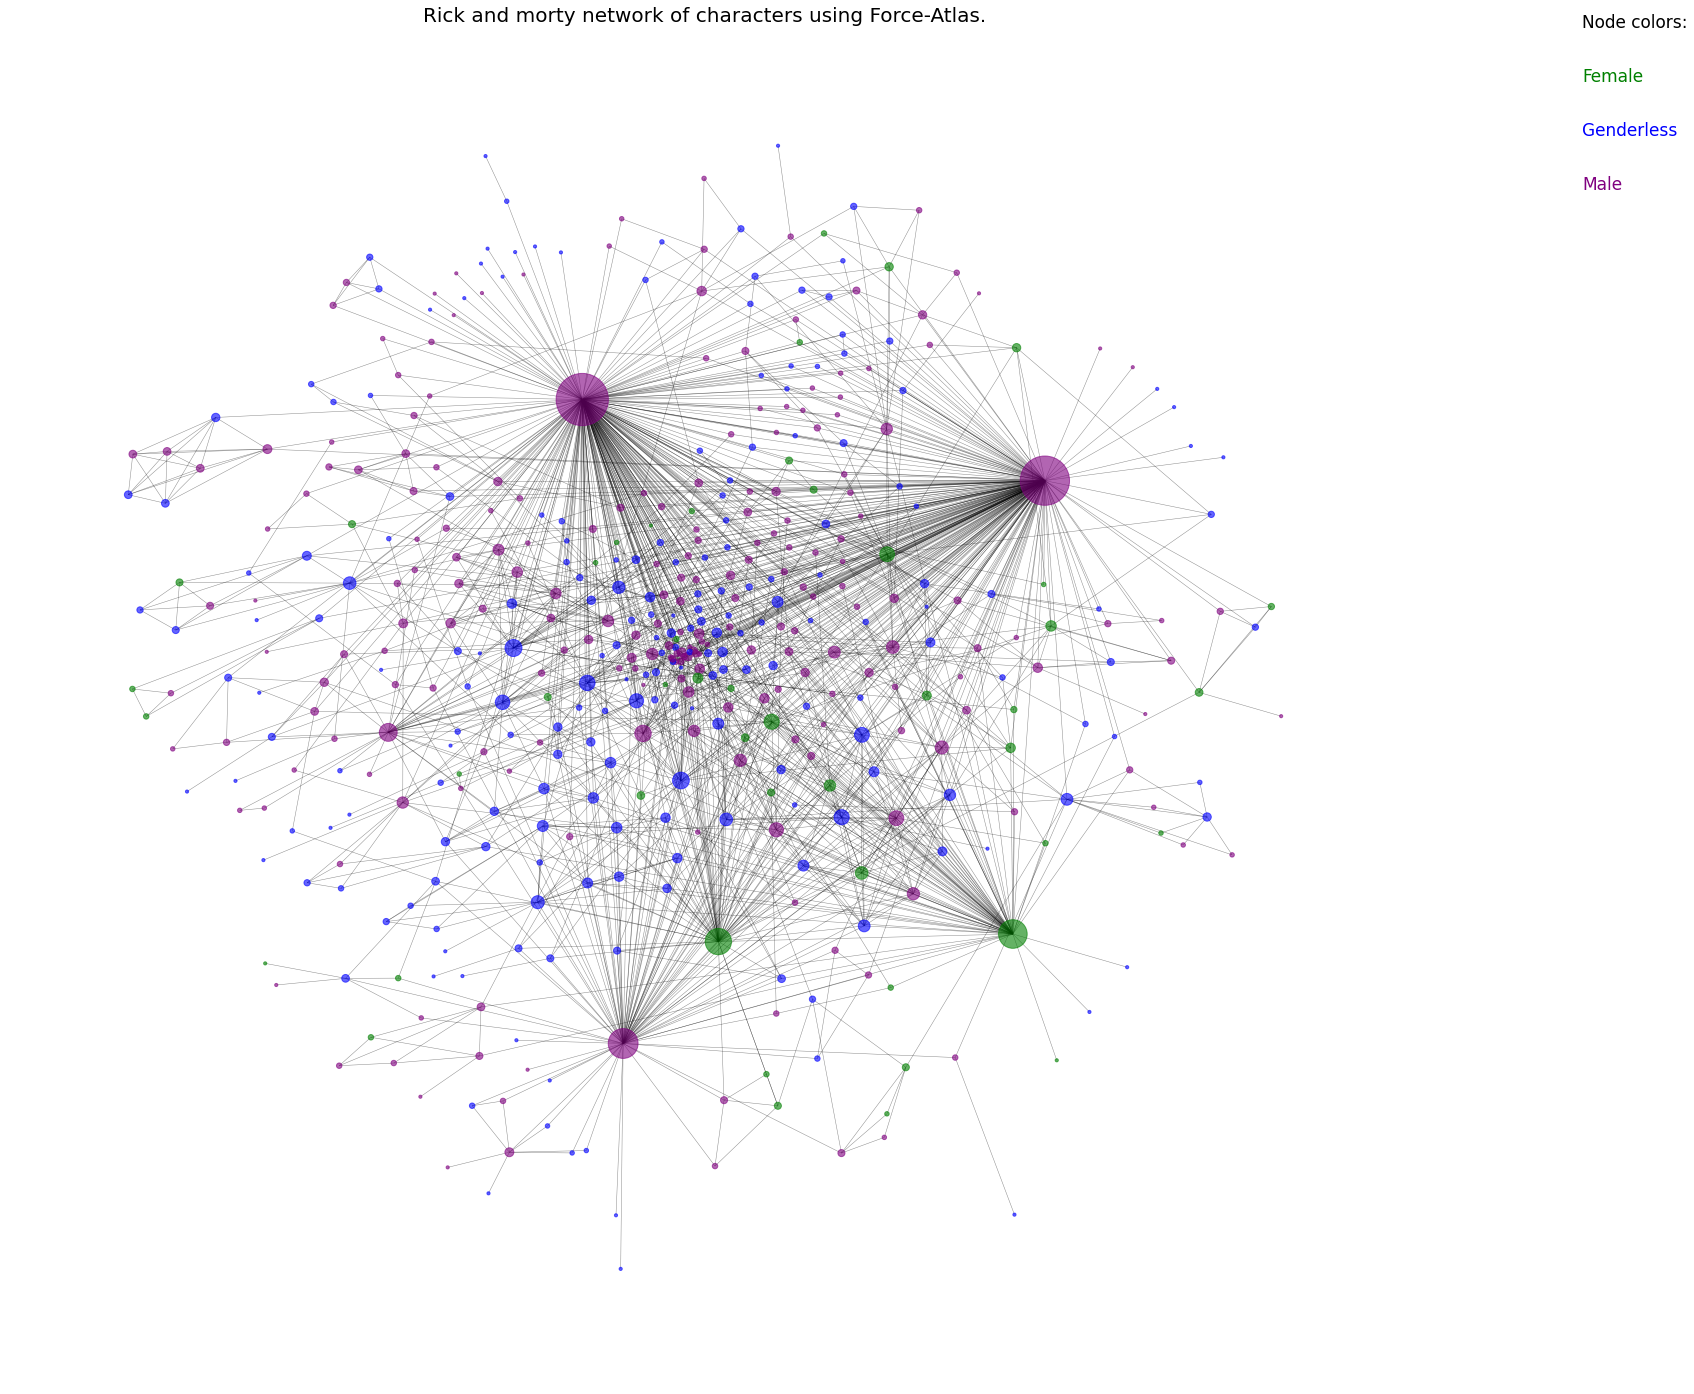

In [215]:
limits = plt.axis("off") 
import fa2
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False, 
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=70.0,
                        strongGravityMode=False,
                        gravity=400.0,

                        # Log
                        verbose=True)

# get node positions from force atlas
pos = forceatlas2.forceatlas2_networkx_layout(G_to_draw, pos=None, iterations=2000)

# plot network

plt.figure(figsize = [25, 25])

nx.draw_networkx_nodes(G_to_draw,pos=pos, node_size=[v*10  for v in d.values()], node_color=colors_list, alpha=0.6)
nx.draw_networkx_edges(G_to_draw,pos=pos, width=0.5, alpha=0.45, arrows=False)

plt.axis('off')

y = 0.88 # This is the starting y position for the figure legend
plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
colots_node = ['green','blue', "purple"]
role_node = ['Female', 'Genderless','Male']
y -= 0.03
for i in range(3):
    plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
    y -= 0.03

plt.title("Rick and morty network of characters using Force-Atlas.", fontsize=20)

plt.show()

In [216]:
best_partition = community_louvain.best_partition(GU)


def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

best_partition_subgraphs = get_partition_from_nodes_attributes(best_partition, G)

print(f"The partition based on Louvain-algorithm detects {len(list(best_partition_subgraphs.keys()))} communities.")

The partition based on Louvain-algorithm detects 16 communities.


In [217]:
index = df_characters_clean.index

for index, value in best_partition.items():
    mask = df_characters_clean["Name"] == index
    to_change = df_characters_clean.index[mask]
    df_characters_clean.loc[to_change, "community"] = value
df_characters_clean.to_csv("df_characters_with_attr_and_communities.csv", index=False)

In [218]:
print(f"The Louvain algorithm found {len(set(best_partition.values()))} communities for the botw network.\
The modularity is {community.modularity(best_partition, GU):.2f}")

The Louvain algorithm found 16 communities for the botw network.The modularity is 0.47


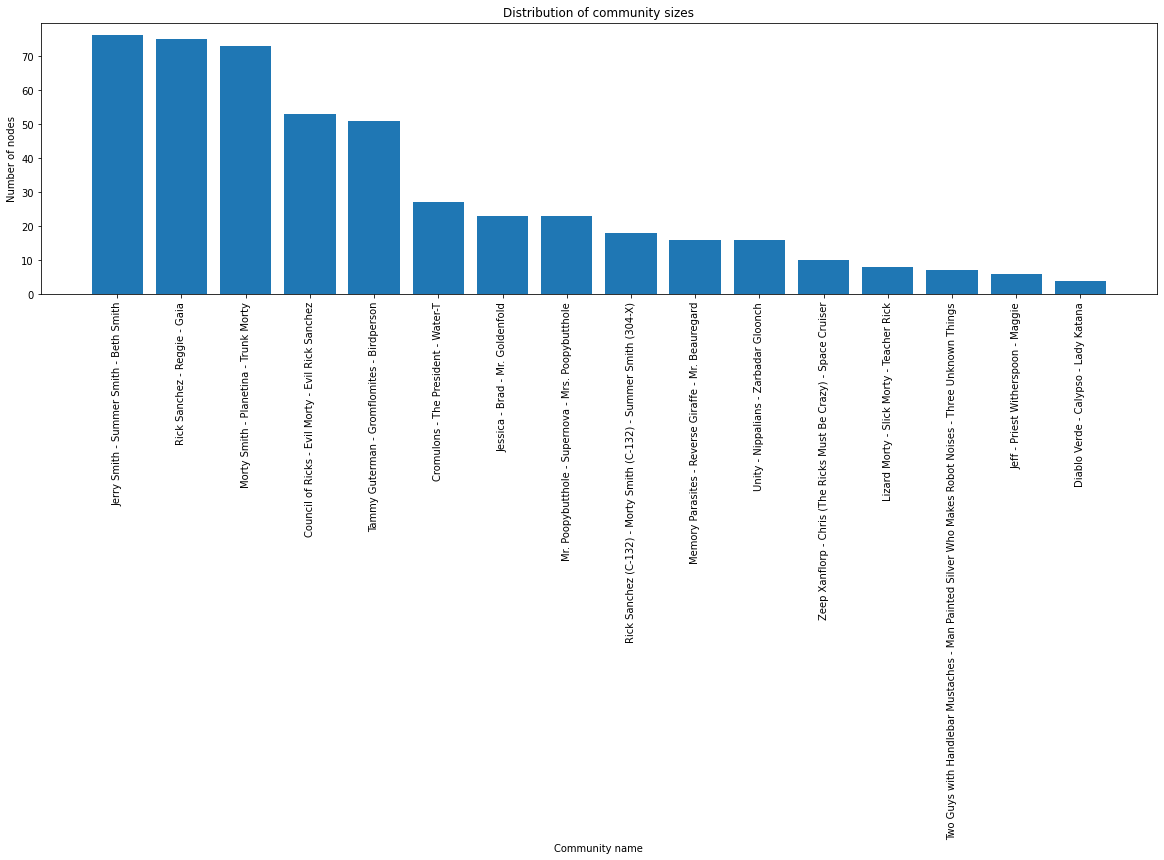

In [219]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in best_partition_subgraphs.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(best_partition.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))

# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values())
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes")
plt.show()



In [220]:
def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

def get_modularity(communities_dic, aGraph):
    """ Get the modularity M of the partition of a graph aGraph given through the dictionary of subgraphs communities_dic """
    L = aGraph.number_of_edges()
    M = 0
    for _, aCommunityGraph in communities_dic.items():
        Lc = aCommunityGraph.number_of_edges()
        kc = sum(list(dict(aCommunityGraph.degree).values()))
        M += (Lc/L - (kc/(2*L))**2)
    print("Modularity M = {}".format(round(M, 2)))
    return M

species_dict = pd.Series(df_characters_clean.Species.values, index=df_characters_clean.Name).to_dict()

part_comm_based_on_origin = get_partition_from_nodes_attributes(species_dict, G)
print(f"The partition based on species detects {len(list(part_comm_based_on_origin.keys()))} communities.")


print("For the partition based on species:")
species_partition_modularity = get_modularity(part_comm_based_on_origin, G)

The partition based on species detects 22 communities.
For the partition based on species:
Modularity M = 0.29


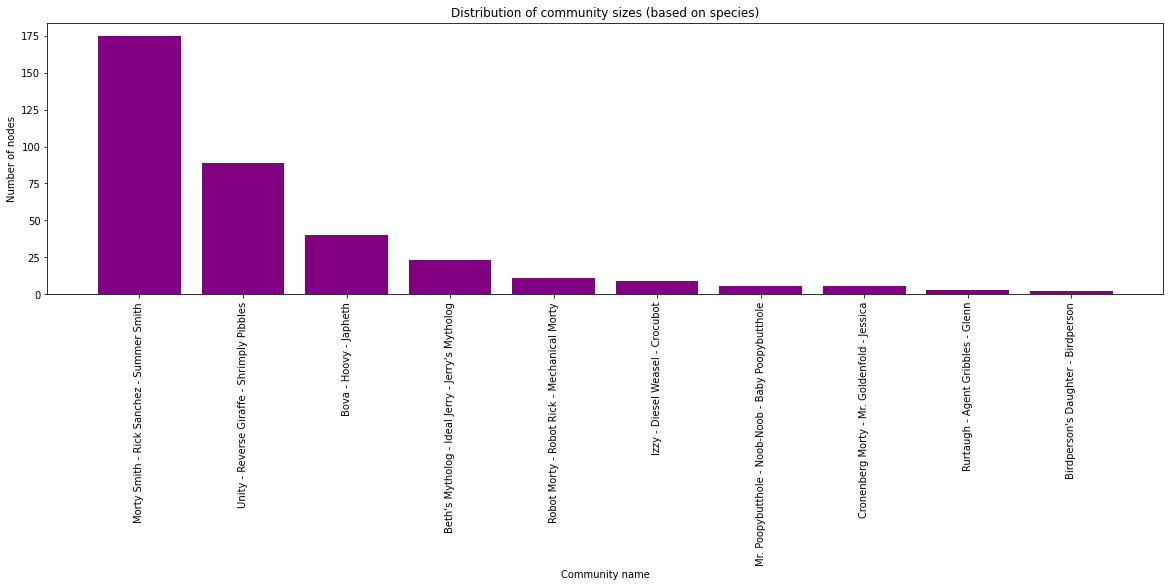

In [224]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in part_comm_based_on_origin.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(species_dict.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))

best_partition_counter = {key:val for key, val in best_partition_counter.items() if val != 1}

best_partition_counter = {key:val for key, val in best_partition_counter.items() if key != 'unknown'}


# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values(), color='purple')
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes (based on species)")
plt.show()